In [1]:
!pip install torchinfo --user

DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/dill-0.3.9-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/igraph-0.11.8-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/lightning_thunder-0.2.0.dev0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/lightning_utilities-0.11.8-py3.12.egg is deprecated. pi

In [2]:
# https://pytorch.org/vision/stable/models.html

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision.transforms import transforms
import os
import numpy as np
import zipfile
from torchinfo import summary
from PIL import Image
from sklearn.model_selection import train_test_split
from pytorchtools import EarlyStopping

In [4]:
torch.__version__

'2.6.0a0+df5bbc09d1.nv24.11'

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [8]:
# 這邊的壓縮檔「cats_dogs.zip」路徑要記得改成正確的路徑！

with zipfile.ZipFile('../0628/cats_dogs.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [9]:
label_dict = {'dog':0, 'cat':1}
labelreverse = {v: k for k, v in label_dict.items()}
labelreverse

{0: 'dog', 1: 'cat'}

In [10]:
image_ext = ['jpg', 'png']

In [11]:
def collect_data(folder:str):
  all_data = []
  all_label = []

  for im_cls in os.listdir("./dataset/%s"%folder):
    if im_cls == "dogs":
      for im_path in os.listdir("./dataset/%s/dogs/"%folder):
        ext = im_path.split('.')[-1]
        if ext in image_ext:
          all_data.append("./dataset/%s/dogs/"%folder+im_path)
          all_label.append(0)
    elif im_cls == "cats":
      for im_path in os.listdir("./dataset/%s/cats/"%folder):
        ext = im_path.split('.')[-1]
        if ext in image_ext:
          all_data.append("./dataset/%s/cats/"%folder+im_path)
          all_label.append(1)

  return all_data, all_label



In [12]:
all_data, all_label = collect_data("training_set")

print('All data size : ', len(all_data))
print('All label size : ', len(all_label))

All data size :  8005
All label size :  8005


In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(all_data,
                                                    all_label,
                                                    test_size=0.2,
                                                    stratify=all_label,
                                                    shuffle=True)

In [14]:
print("Train data Dog count : ", y_train.count(0))
print("Train data Cat count : ", y_train.count(1))
print("Valid data Dog count : ", y_valid.count(0))
print("Valid data Cat count : ", y_valid.count(1))

Train data Dog count :  3204
Train data Cat count :  3200
Valid data Dog count :  801
Valid data Cat count :  800


In [15]:
aug = transforms.RandomOrder([
    transforms.RandomHorizontalFlip(p=0.3),
    # transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-10, 10)),
    # transforms.GaussianBlur(kernel_size=(5, 5)),
])

In [16]:
norm = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], #(input - mean) / std, (R, G, B)
                  std=[0.229, 0.224, 0.225]) # from imagenet dataset
])

In [17]:
class Image_dataset(Dataset):
    def __init__(self, X_data, y_data, mode):
        self.X_data = X_data        # 輸入的訓練資料
        self.y_data = y_data        # 輸入訓練資料的標籤
        self.mode = mode
        self.norm = norm
        if mode =='train':
          self.augmentation = aug

    def __getitem__(self, index):
        data_path = self.X_data[index]
        image = Image.open(data_path)
        image_tensor = self.norm(image)
        if self.mode =='train':
          image_tensor = self.augmentation(image_tensor)

        target = torch.tensor(int(self.y_data[index]), dtype=torch.long)

        return image_tensor,target

    def __len__(self):
        return len(self.X_data)

In [18]:
train_data = Image_dataset(X_train, y_train, mode='train')
train_loader = DataLoader(
    train_data,
    batch_size=64,
    shuffle=True
    )

valid_data = Image_dataset(X_valid, y_valid, mode='valid')
valid_loader = DataLoader(
    valid_data,
    batch_size=64,
    shuffle=False
    )

In [19]:
dataiter = iter(train_loader)   #迭代器
inputs,labels = next(dataiter)

print(inputs.size())
print(labels.size())


torch.Size([64, 3, 224, 224])
torch.Size([64])


In [20]:
def activation_func(activation):
    return nn.ModuleDict({
        'relu': nn.ReLU(inplace=True),
        'leaky_relu': nn.LeakyReLU(negative_slope=0.01, inplace=True),
        'sigmoid': nn.Sigmoid(),
        'prelu': nn.PReLU(),
        'softmax': nn.Softmax(dim=1),
        'gelu': nn.GELU()})[activation]

In [21]:
class Fullyconnect(nn.Module):
    def __init__(self, in_channels, out_channel, activation):
        super().__init__()
        self.fc = nn.Linear(in_channels, out_channel)
        self.actfunction = activation_func(activation)

    def forward(self, x):
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        x = self.actfunction(x)
        return x

In [22]:
# Model structure
class ModelStructure(nn.Module):
    def __init__(self, cls):
        super().__init__()
        self.cls = cls

        self.densent = models.densenet121(pretrained=True)
        print(self.densent)
        self.densent.classifier = Fullyconnect(1024, self.cls, 'softmax')
    def forward(self, x):
        x = self.densent(x)
        return x

cnn_model = ModelStructure(cls=2).to(device)

test_tensor = torch.randn((1, 3, 224, 224)).to(device)
output = cnn_model(test_tensor)
print(output.size())

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [23]:
summary(cnn_model, input_data=test_tensor)

Layer (type:depth-idx)                        Output Shape              Param #
ModelStructure                                [1, 2]                    --
├─DenseNet: 1-1                               [1, 2]                    --
│    └─Sequential: 2-1                        [1, 1024, 7, 7]           --
│    │    └─Conv2d: 3-1                       [1, 64, 112, 112]         9,408
│    │    └─BatchNorm2d: 3-2                  [1, 64, 112, 112]         128
│    │    └─ReLU: 3-3                         [1, 64, 112, 112]         --
│    │    └─MaxPool2d: 3-4                    [1, 64, 56, 56]           --
│    │    └─_DenseBlock: 3-5                  [1, 256, 56, 56]          335,040
│    │    └─_Transition: 3-6                  [1, 128, 28, 28]          33,280
│    │    └─_DenseBlock: 3-7                  [1, 512, 28, 28]          919,680
│    │    └─_Transition: 3-8                  [1, 256, 14, 14]          132,096
│    │    └─_DenseBlock: 3-9                  [1, 1024, 14, 14]         

In [24]:
# 可以先查看所有layers的名稱
for name, param in cnn_model.named_parameters():
    if param.requires_grad:
        print(name)


densent.features.conv0.weight
densent.features.norm0.weight
densent.features.norm0.bias
densent.features.denseblock1.denselayer1.norm1.weight
densent.features.denseblock1.denselayer1.norm1.bias
densent.features.denseblock1.denselayer1.conv1.weight
densent.features.denseblock1.denselayer1.norm2.weight
densent.features.denseblock1.denselayer1.norm2.bias
densent.features.denseblock1.denselayer1.conv2.weight
densent.features.denseblock1.denselayer2.norm1.weight
densent.features.denseblock1.denselayer2.norm1.bias
densent.features.denseblock1.denselayer2.conv1.weight
densent.features.denseblock1.denselayer2.norm2.weight
densent.features.denseblock1.denselayer2.norm2.bias
densent.features.denseblock1.denselayer2.conv2.weight
densent.features.denseblock1.denselayer3.norm1.weight
densent.features.denseblock1.denselayer3.norm1.bias
densent.features.denseblock1.denselayer3.conv1.weight
densent.features.denseblock1.denselayer3.norm2.weight
densent.features.denseblock1.denselayer3.norm2.bias
densen

In [25]:
freeze_name = ["densent.features.denseblock4.denselayer16.norm1.weight",
               "densent.features.denseblock4.denselayer16.norm1.bias",
               "densent.features.denseblock4.denselayer16.conv1.weight",
               "densent.features.denseblock4.denselayer16.norm2.weight",
               "densent.features.denseblock4.denselayer16.norm2.bias",
               "densent.features.denseblock4.denselayer16.conv2.weight",
               "densent.features.norm5.weight",
               "densent.features.norm5.bias"]

In [26]:
# 再決定要layer freeze哪幾層
for name, param in cnn_model.named_parameters():
    if name in freeze_name:
        print(name)
        param.requires_grad = False
        

densent.features.denseblock4.denselayer16.norm1.weight
densent.features.denseblock4.denselayer16.norm1.bias
densent.features.denseblock4.denselayer16.conv1.weight
densent.features.denseblock4.denselayer16.norm2.weight
densent.features.denseblock4.denselayer16.norm2.bias
densent.features.denseblock4.denselayer16.conv2.weight
densent.features.norm5.weight
densent.features.norm5.bias


In [27]:
summary(cnn_model, input_data=test_tensor)

Layer (type:depth-idx)                        Output Shape              Param #
ModelStructure                                [1, 2]                    --
├─DenseNet: 1-1                               [1, 2]                    --
│    └─Sequential: 2-1                        [1, 1024, 7, 7]           --
│    │    └─Conv2d: 3-1                       [1, 64, 112, 112]         9,408
│    │    └─BatchNorm2d: 3-2                  [1, 64, 112, 112]         128
│    │    └─ReLU: 3-3                         [1, 64, 112, 112]         --
│    │    └─MaxPool2d: 3-4                    [1, 64, 56, 56]           --
│    │    └─_DenseBlock: 3-5                  [1, 256, 56, 56]          335,040
│    │    └─_Transition: 3-6                  [1, 128, 28, 28]          33,280
│    │    └─_DenseBlock: 3-7                  [1, 512, 28, 28]          919,680
│    │    └─_Transition: 3-8                  [1, 256, 14, 14]          132,096
│    │    └─_DenseBlock: 3-9                  [1, 1024, 14, 14]         

In [28]:
optimizer = torch.optim.AdamW(cnn_model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

In [29]:
early_stopping = EarlyStopping(patience=5,
                               verbose=True,
                               save_model=True,
                               path="save_model/best.pt")

In [30]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode='min',
                                                       factor=0.1,
                                                       patience=3,
                                                       verbose=True)

/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [31]:
if not os.path.exists('save_model'):
  os.mkdir('save_model')

In [32]:
n_epochs = 5
i_iter = 0


train_losses = []
valid_losses = []
train_accs = []
valid_accs = []


for epoch in range(n_epochs):
    b_train_loss = []
    b_valid_loss = []
    b_train_acc = []
    b_valid_acc = []
    for idx, (imgs, labels) in enumerate(train_loader):
        cnn_model.train()
        n_correct_train = 0
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = cnn_model(imgs)

        train_loss = loss_fn(outputs, labels)
        train_loss.backward()
        optimizer.step()

        train_outputs_label = torch.argmax(outputs, 1)
        n_correct_train = len(torch.where(train_outputs_label == labels)[0])/len(labels)


        b_train_loss.append(train_loss.item())
        b_train_acc.append(n_correct_train)

    n_correct_val = 0
    n_val_data = 0
    cnn_model.eval()
    with torch.no_grad():
        for _idx, (imgs, labels) in enumerate(valid_loader):
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = cnn_model(imgs)
            val_loss = loss_fn(outputs, labels)

            val_outputs_label = torch.argmax(outputs, 1)
            n_correct_val = len(torch.where(val_outputs_label == labels)[0])/len(labels)

            b_valid_loss.append(val_loss.item())
            b_valid_acc.append(n_correct_val)

    ep_train_loss = np.mean(b_train_loss)
    ep_vaild_loss = np.mean(b_valid_loss)
    ep_train_acc = np.mean(b_train_acc)
    ep_valid_acc = np.mean(b_valid_acc)

    train_losses.append(ep_train_loss)
    valid_losses.append(ep_vaild_loss)
    train_accs.append(ep_train_acc)
    valid_accs.append(ep_valid_acc)

    print(f'{epoch + 1:2d}/{n_epochs:2d} {idx + 1:3d}/{len(train_loader):3d}, \
        train loss: {ep_train_loss:8.5f}, \
        train acc: {ep_train_acc:7.5f}, \
        val loss: {ep_vaild_loss:8.5f}, \
        val acc: {ep_valid_acc:7.5f}')

    scheduler.step(ep_vaild_loss)

    early_stopping(ep_vaild_loss, cnn_model)
    i_iter += 1

    if early_stopping.early_stop:
      print("[INFO] Early stopping")
      break

 1/ 5 101/101,         train loss:  0.39520,         train acc: 0.91399,         val loss:  0.41335,         val acc: 0.89363
Validation loss decreased (inf --> 0.413351).  Saving model ...
 2/ 5 101/101,         train loss:  0.38587,         train acc: 0.92481,         val loss:  0.42608,         val acc: 0.87921
EarlyStopping counter: 1 out of 5
 3/ 5 101/101,         train loss:  0.39098,         train acc: 0.91692,         val loss:  0.41548,         val acc: 0.89483
EarlyStopping counter: 2 out of 5
 4/ 5 101/101,         train loss:  0.36827,         train acc: 0.94106,         val loss:  0.40123,         val acc: 0.91046
Validation loss decreased (0.413351 --> 0.401233).  Saving model ...
 5/ 5 101/101,         train loss:  0.36270,         train acc: 0.94787,         val loss:  0.39351,         val acc: 0.91406
Validation loss decreased (0.401233 --> 0.393510).  Saving model ...


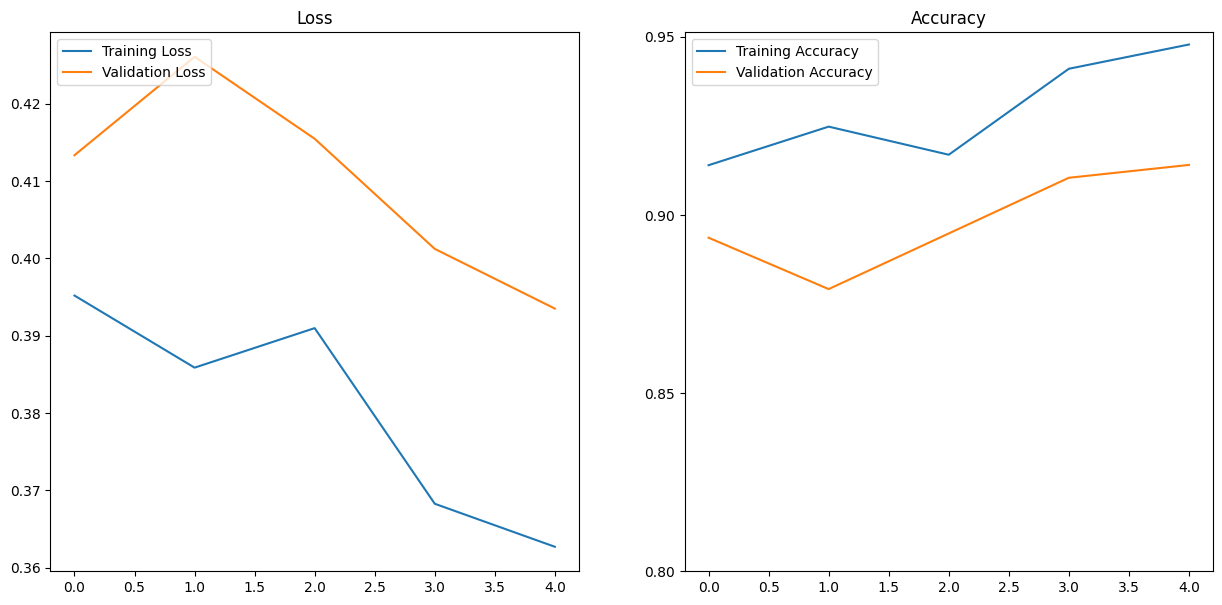

In [33]:
import matplotlib.pyplot as plt
# 視覺化訓練過程
plt.figure(figsize=(15, 7))

# 繪製 Training loss 和 Validation loss
plt.subplot(121)
plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(len(valid_losses)), valid_losses, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('Loss')

# 繪製 Training accuracy 和 Validation accuracy
plt.subplot(122)
plt.plot(range(len(train_accs)), train_accs, label='Training Accuracy')
plt.plot(range(len(valid_accs)), valid_accs, label='Validation Accuracy')
plt.yticks(np.arange(0.8, 1, 0.05))
plt.legend(loc='upper left')
plt.title('Accuracy')

plt.show()

In [47]:
test_preds = []
cnn_model.load_state_dict(torch.load("save_model/best.pt"))
cnn_model.to(device)

test_data, test_label = collect_data("test_set")
print("test image size:" , len(test_data))
for path in test_data:
    image = Image.open(path)
    image_tensor = norm(image)
    image_tensor = torch.unsqueeze(image_tensor, dim=0)
    image_tensor = image_tensor.to(device)
    outputs = cnn_model(image_tensor)
    pred = torch.argmax(outputs, 1).item()
    test_preds.append(pred)

/tmp/ipykernel_6093/1687478100.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_model.load_state_dict(torch.load("save_model/best.pt"))


test image size: 2023


In [48]:
cnn_model

ModelStructure(
  (densent): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momen

In [49]:
from sklearn import metrics
target_names = ['dog', 'cat']
print(metrics.classification_report(test_label, test_preds, target_names=target_names))

              precision    recall  f1-score   support

         dog       0.95      0.88      0.91      1012
         cat       0.89      0.95      0.92      1011

    accuracy                           0.92      2023
   macro avg       0.92      0.92      0.92      2023
weighted avg       0.92      0.92      0.92      2023

